#Project# 1

# Inference Pipeline for Face Recognition Systems
- For detection of faces we will use MTCNN
- For the alignment, to maintain the simplicity of the scope of this kernel we will only use 2D alignment
- We will then use our model to extract the features

<img src='https://www.researchgate.net/publication/282863610/figure/fig1/AS:669508570214408@1536634690438/Processing-pipeline-of-face-recognition.jpg'>



*   *Develop a Face Recognition System Using
FaceNet for your classmate*
* **[3 pt]**   Collect a dataset for you and your classmate to do your system

* **[2 pt]** Do a Face_Verification function that verifies that the two images for the same person
  * The function Input is the path of two images.
  * It checks whether both images belong to the same person.
  * It returns "same Person" or "not same person" and the distance between them
  * recognition = Face_Verification("./image1.jpg",  "./image2.jpg")
* **[5 pt]**  Do a **Face_Recognition** A function that clusters an Image to a specific folder in a labeled database
  * The function Input is the image and folder path.
  * It returns a dictionary of the nearest label folders to the input image and its distance.
  * recognition = Face_Recognition("./test_image.jpg",  "./labeld_database")

---
**you may use these steps**

* Read an image and Detect the face
*  perform alignment
* Extract face embeddings
* Calculate the distance between embeddings present in the database and extracted input face embeddings
*  Find the index of the lowest distance, and check if the distance is less than a threshold
  * If yes then use the index to find the person from the database
  * Else the person in the input image is not present in the database
*  Use the OpenCV utilities to tag the person in the image
* cluster faces using SVM
* visualize each step

# **IMPORT**




In [ ]:
from os import listdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN
from keras_facenet import FaceNet
from os import listdir
from os.path import join
import os
from keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import math
import cv2
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

# DATASET

**Mount google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install keras-facenet
#Detect Faces
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Access spesific path on my Drive
%cd /content/drive/MyDrive/TRIAL2/IMAGE

/content/drive/MyDrive/TRIAL2/IMAGE


In [ ]:
%ls

archive.zip  facenet_keras.h5  img_dataset/  Random_Faces/


In [ ]:
#confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


visualizing one of the images in the dataset

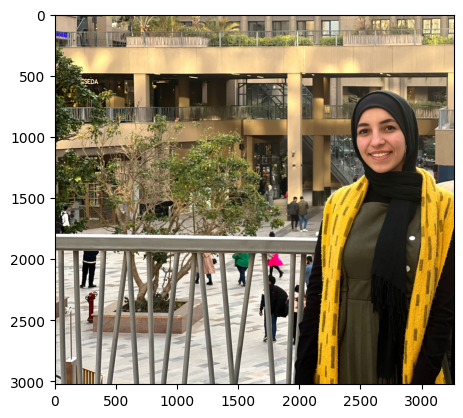

(3024, 3264, 3)

In [ ]:
# Read datasets
image = Image.open('/content/drive/MyDrive/IMAAA/img_dataset/Hajar Fawzi/Copy of 20230128_042016.jpg')
# convert to RGB, if needed
image = image.convert('RGB')
# convert to array
image = asarray(image)
plt.imshow(image)
plt.show()
image.shape

# FACE DETECTION

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def Face_detection(image_path):
  detector = MTCNN()
  # detect faces in the image
  results = detector.detect_faces(image)
  if len(results) == 0:
    print("No faces were detected in image.")
    return False
  # extract the bounding box from the first face
  x1, y1, width, height = results[0]['box']
  # bug fix
  x1, y1 = abs(x1), abs(y1)
  x2, y2 = x1 + width, y1 + height
  # extract the face
  face = image[y1:y2, x1:x2]
  plt.imshow(face)
  plt.text(1,2,"First case")
  plt.show()
  print(face.shape)

  #  Load the image
  # Detect the face region using your face detection algorithm
  face_O = [x1, y1, width, height]
  # Plot the image
  fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(image)
  # Create a rectangle patch for the face region
  rect = patches.Rectangle((face_O[0], face_O[1]), face_O[2], face_O[3], linewidth=2, edgecolor='y', facecolor='none')
  # Add the rectangle patch to the plot
  ax.add_patch(rect)

# Show the plot
  plt.show()



# Visualizing Face detection in two ways


1/1 [==============================] - 0s 149ms/step


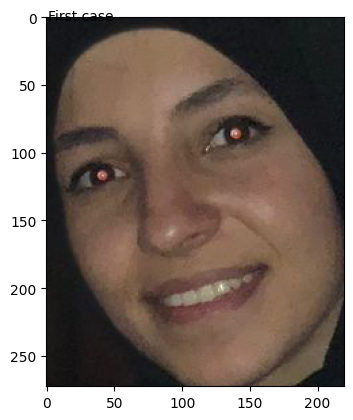

(273, 220, 3)


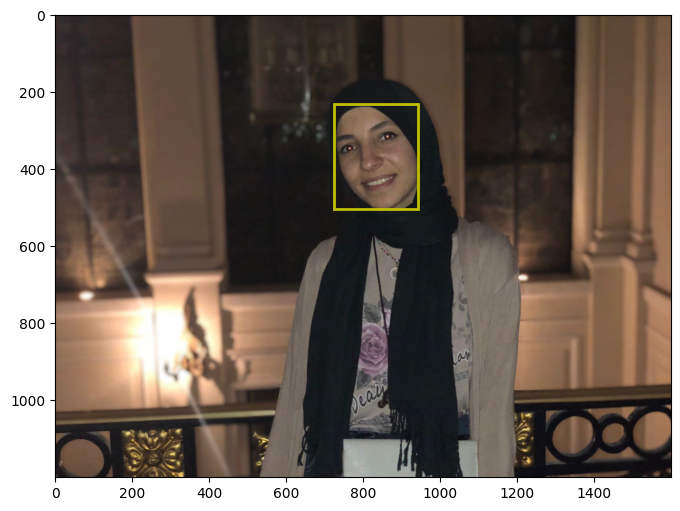

In [ ]:
image = plt.imread("/content/drive/MyDrive/img_dataset/Hajar Fawzi/Copy of IMG-20220509-WA0213.jpg")
Face_detection(image)

In [ ]:
from keras_facenet import FaceNet
embedder = FaceNet()
# get the face embedding for one face
facenet_model=embedder.model

In [ ]:
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]

# Face Verification

[2 pt] Do a Face_Verification function that verifies that the two images for the same person

The function Input is the path of two images.
It checks whether both images belong to the same person.
It returns "same Person" or "not same person" and the distance between them
recognition = Face_Verification("./image1.jpg", "./image2.jpg")

In [ ]:
def Face_Verification(image1_path,image2_path):
  image1=cv2.imread(image1_path)
  image2=cv2.imread(image2_path)
  # create the detector, using default weights
  detector = MTCNN()
# detect faces in the image
  result1 = detector.detect_faces(image1)
  result2=  detector.detect_faces(image2)
  if len(result1) == 0:
    print("No faces were detected in image 1.")
    return False
  if len(result2) == 0:
    print("No faces were detected in image 2.")
    return False
  x1_1, y1_1, width_1, height_1 = result1[0]['box']
  x1_1, y1_1 = abs(x1_1), abs(y1_1)
  x2_1, y2_1 = x1_1 + width_1, y1_1 + height_1

  x1_2, y1_2, width_2, height_2 = result2[0]['box']
  x1_2, y1_2 = abs(x1_2), abs(y1_2)
  x2_2, y2_2 = x1_2 + width_2, y1_2 + height_2

  face1 = image1[y1_1:y2_1, x1_1:x2_1]
  face2 = image2[y1_2:y2_2, x1_2:x2_2]
  plt.imshow(face1)
  plt.show()
  plt.imshow(face2)
  plt.show()

  embedding1=get_embedding(facenet_model,face1)
  embedding2=get_embedding(facenet_model,face2)
  detect_1 = embedder.extract(image1_path, threshold=0.65)
  detect_2 = embedder.extract(image2_path, threshold=0.65)
  distance = embedder.compute_distance(detect_1[0]['embedding'], detect_2[0]['embedding'])
  if distance <.65:
     return ('Same Person'),distance
  else :
    return ('Not the Same Person'),distance


# Face Verification vizualization

1/1 [==============================] - 0s 23ms/step


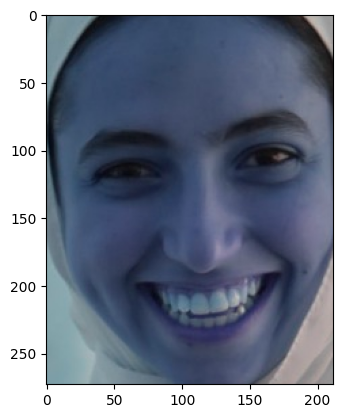

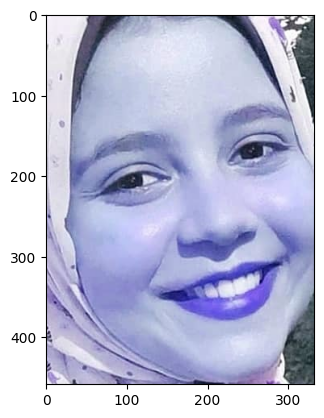

1/1 [==============================] - 0s 129ms/step


1/1 [==============================] - 0s 117ms/step
('Not the Same Person', 0.74201899766922)


In [ ]:
recognition=Face_Verification("/content/drive/MyDrive/img_dataset/Mariam Elseedawy/IMG_20220918_232240_970.jpg","/content/drive/MyDrive/img_dataset/Riham Hussain/IMG-20230416-WA0014.jpg")
print(recognition)

1/1 [==============================] - 0s 28ms/step


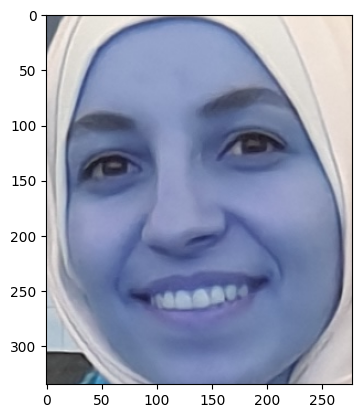

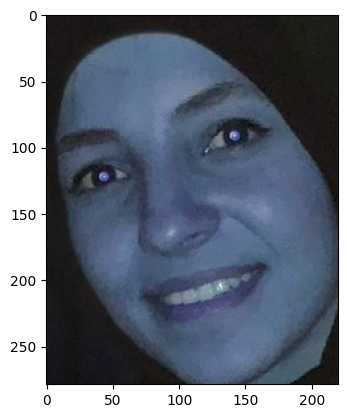

1/1 [==============================] - 0s 78ms/step
('Same Person', 0.19065290689468384)


In [ ]:
recognition=Face_Verification("/content/drive/MyDrive/IMAAA/img_dataset/Hajar Fawzi/Copy of 20221123_164757.jpg","/content/drive/MyDrive/IMAAA/img_dataset/Hajar Fawzi/Copy of IMG-20220509-WA0213.jpg")
print(recognition)

# Face Recognission

[5 pt] Do a Face_Recognition A function that clusters an Image to a specific folder in a labeled database

The function Input is the image and folder path.
It returns a dictionary of the nearest label folders to the input image and its distance.
recognition = Face_Recognition("./test_image.jpg", "./labeld_database")

In [ ]:
def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + '/' + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)


# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

In [ ]:
embedder = FaceNet()
facenet_model=embedder.model
def Face_Recognition(Image_path :str, dataset_path : str):
    trainx , trainy = load_dataset(dataset_path);
    emdTrainX = [get_embedding(facenet_model , x ) for x in trainx]
    in_encoder = Normalizer()
    emdTrainX_norm = in_encoder.transform(emdTrainX)
    out_encoder = LabelEncoder()
    out_encoder.fit(trainy)
    trainy_enc = out_encoder.transform(trainy)
    model = SVC(probability=True)
    model.fit(emdTrainX_norm, trainy_enc)
    yhat_train = model.predict(emdTrainX_norm)
    score_train = accuracy_score(trainy_enc, yhat_train)
    print('Accuracy: train=%.3f' % (score_train*100))

    test_face = extract_face(Image_path).astype(float)/255.0
    face_embd = get_embedding(facenet_model ,test_face )

    samples = np.expand_dims(face_embd, axis=0)
    yhat_class = model.predict(samples)
    yhat_prob = model.predict_proba(samples)
    class_index = yhat_class[0]
    class_probability = yhat_prob[0,class_index]
    predict_names = out_encoder.inverse_transform(yhat_class)
    all_names = out_encoder.inverse_transform([0,1,2,3,4,5])
    print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
    # plot face

    #print('Maximum: \n%s \n%s' %(max((all_names, yhat_prob[0]*100).values)))
    return {key : val for key , val in zip(all_names ,yhat_prob[0] )}

# Visualization of face recognision

In [ ]:
Face_Recognition("/content/drive/MyDrive/IMAAA/img_dataset/AL-Limby/El-Lemby004.jpg","/content/drive/MyDrive/IMAAA/img_dataset")

1/1 [==============================] - 0s 124ms/step
loaded 10 sample for class: Jihad Mahmoud
1/1 [==============================] - 0s 132ms/step
loaded 8 sample for class: Mariam Elseedawy
1/1 [==============================] - 0s 127ms/step
loaded 9 sample for class: Riham Hussain
1/1 [==============================] - 0s 143ms/step
loaded 11 sample for class: Muhammad Khalid
1/1 [==============================] - 0s 228ms/step
loaded 9 sample for class: Hajar Fawzi
1/1 [==============================] - 0s 133ms/step
loaded 10 sample for class: Ahmed Helmy
1/1 [==============================] - 0s 129ms/step
loaded 10 sample for class: Tony_Blair
1/1 [==============================] - 0s 176ms/step
loaded 10 sample for class: Jacques_Chirac
1/1 [==============================] - 0s 141ms/step
loaded 10 sample for class: George_W_Bush
1/1 [==============================] - 0s 128ms/step
loaded 10 sample for class: Donald_Rumsfeld
1/1 [==============================] - 0s 154ms/step

{'AL-Limby': 0.6522895868610722,
 'Ahmed Helmy': 0.04740447818585409,
 'Colin_Powell': 0.012561840678544552,
 'Donald_Rumsfeld': 0.01875492517549814,
 'George_W_Bush': 0.027447291352621517,
 'Gerhard_Schroeder': 0.01748971679437146}